<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/7_1b_Model_Audio_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Audio Features
### Table of Contents
- Import Data
  - Define Data and target
  - EDA
  - Scale Data
- Model Selection
  - L1/L2 Regularization
  - Decision Tree
  - K-Nearest Neighbors
  - Random Forest
  - Multilayer Perceptron
  - Gradient Boosting
- Model Tuning
- Final Model
- Conclusion

Now that we have Spotify's audio features for our tracks, we can model them using supervised methods. We'll use multiple approaches of varying complexity and select the strongest model based on cross-validation and variance. Once we have selected the best model, we'll fine tune its performance using grid search. Finally, we'll analyze our audio data with our tuned model and see how accurately we can classify songs.

## Import Data

In [0]:
# load packages
import numpy as np
import pandas as pd
# set random seed
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
filename = "spotify_features"
Audio_Features = pd.read_csv(filename + ".csv", index_col=0)

Audio_Features.head()

,target,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,,
005lwxGU1tms6HGELIcUv9,1,0.00223,0.699,179640,0.7600,False,0.000000,5,0.1320,-3.173,1,67,0.0677,129.996,4,0.6960
008EXmFGIPz7DWuOVIl5hP,0,0.94700,0.355,265189,0.1920,False,0.014000,10,0.1120,-14.117,1,7,0.0310,121.412,4,0.0905
00AVBnaQz7yRv8NTpNlCVU,0,0.92200,0.483,172000,0.0838,False,0.000017,5,0.1020,-12.349,1,33,0.0561,75.458,1,0.1620
00DTeE4nekCTgYz1QYHXSl,0,0.68400,0.543,184000,0.4670,False,0.006040,4,0.3510,-11.223,1,58,0.2740,75.293,4,0.3280
00DrIsn8msfbQf3Let6UTD,0,0.70500,0.518,136500,0.4790,False,0.878000,0,0.0968,-15.971,1,53,0.0519,80.005,4,0.2200


In [0]:
# define dataframes to store results
model_desc = []
model_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=None, cv=5):
  """
  """
  #from sklearn.model_selection import train_test_split, cross_val_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify)
  
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nValidation score:', test_score)
  
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_score = np.round(np.mean(cv_scores)*100, 4)
  variance = np.round(np.var(cv_scores)*100, 4)
  print('\nCross validation: {} +/- {}%'.format(cv_score, variance))
  
  return pd.DataFrame([[train_score, test_score, cv_score, variance]],
                      columns=["train_score", "test_score", "cv_score", "variance"])

In [0]:
def plotting_func(labels_list, data, title_list, nrows=1, ncols=3, figsize=(15,5)):
  """
  """
  num_cols = range(0, ncols)
  num_rows = range(0, ncols)
  
  # plot target variable
  fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
  
  for n in num_plots:
    sns.scatterplot(data[:,0], data[:,1],
                    hue=labels_list[n], ax=axes[n])
    axes[n].set_xlabel(title_list[n])

  fig.suptitle(title_list[-1])
  plt.show;

### Define Data and target

In [0]:
Data = Audio_Features.reset_index().drop(["target", "id"], axis=1)
target = Audio_Features.reset_index()["target"]

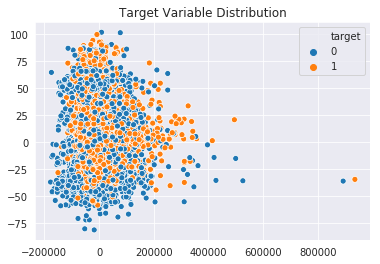

In [9]:
# reduce data to two dimensions
from sklearn.decomposition import PCA
Data_2D = PCA(n_components=2).fit_transform(Data)

sns.scatterplot(Data_2D[:,0], Data_2D[:,1], hue=target)
plt.title("Target Variable Distribution")
plt.show;

### EDA

In [0]:
print(Data.shape)
Data.head()

(8802, 15)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,
005lwxGU1tms6HGELIcUv9,0.00223,0.699,179640,0.7600,False,0.000000,5,0.1320,-3.173,1,67,0.0677,129.996,4,0.6960
008EXmFGIPz7DWuOVIl5hP,0.94700,0.355,265189,0.1920,False,0.014000,10,0.1120,-14.117,1,7,0.0310,121.412,4,0.0905
00AVBnaQz7yRv8NTpNlCVU,0.92200,0.483,172000,0.0838,False,0.000017,5,0.1020,-12.349,1,33,0.0561,75.458,1,0.1620
00DTeE4nekCTgYz1QYHXSl,0.68400,0.543,184000,0.4670,False,0.006040,4,0.3510,-11.223,1,58,0.2740,75.293,4,0.3280
00DrIsn8msfbQf3Let6UTD,0.70500,0.518,136500,0.4790,False,0.878000,0,0.0968,-15.971,1,53,0.0519,80.005,4,0.2200


In [0]:
Data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
count,8802.000000,8802.000000,8.802000e+03,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000
mean,0.334718,0.603835,2.241808e+05,0.568281,0.131980,5.211202,0.167187,-8.737745,0.679959,46.129630,0.069071,118.621527,3.938423,0.483181
std,0.329364,0.150797,6.223853e+04,0.236643,0.275135,3.589402,0.132301,4.169455,0.466518,20.733918,0.072740,28.245427,0.322018,0.248460
min,0.000002,0.104000,4.689500e+04,0.001070,0.000000,0.000000,0.015700,-35.389000,0.000000,0.000000,0.022300,37.114000,1.000000,0.027700
25%,0.037925,0.501000,1.878468e+05,0.394000,0.000001,2.000000,0.093900,-10.730750,0.000000,36.000000,0.033300,97.798500,4.000000,0.280250
50%,0.207000,0.610000,2.166875e+05,0.592000,0.000295,5.000000,0.115000,-7.938500,1.000000,50.000000,0.042600,117.898000,4.000000,0.468000
75%,0.622000,0.714000,2.518632e+05,0.756000,0.051275,8.000000,0.189000,-5.814000,1.000000,60.000000,0.066800,134.046250,4.000000,0.678000
max,0.996000,0.984000,1.159868e+06,0.998000,0.981000,11.000000,0.979000,1.342000,1.000000,100.000000,0.915000,219.925000,5.000000,0.990000


In [0]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8802 entries, 005lwxGU1tms6HGELIcUv9 to 7zuqsNtIkksF5U9OEjqXlk
Data columns (total 15 columns):
acousticness        8802 non-null float64
danceability        8802 non-null float64
duration_ms         8802 non-null int64
energy              8802 non-null float64
explicit            8802 non-null bool
instrumentalness    8802 non-null float64
key                 8802 non-null int64
liveness            8802 non-null float64
loudness            8802 non-null float64
mode                8802 non-null int64
popularity          8802 non-null int64
speechiness         8802 non-null float64
tempo               8802 non-null float64
time_signature      8802 non-null int64
valence             8802 non-null float64
dtypes: bool(1), float64(9), int64(5)
memory usage: 1.3+ MB


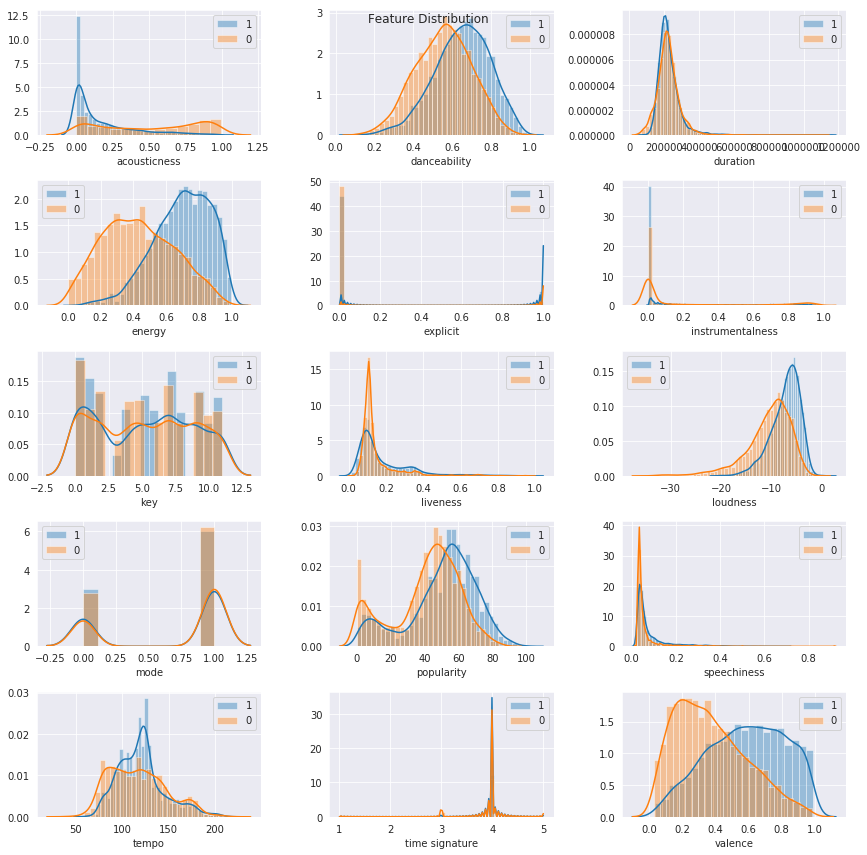

In [0]:
# plot target variable
fig, axes = plt.subplots(5, 3, figsize=(12,12))

sns.distplot(Data["acousticness"].loc[target==1], ax=axes[0,0], label=1)
sns.distplot(Data["acousticness"].loc[target==0], ax=axes[0,0], label=0)
axes[0,0].set_xlabel("acousticness")
axes[0,0].legend()

sns.distplot(Data["danceability"].loc[target==1], ax=axes[0,1], label=1)
sns.distplot(Data["danceability"].loc[target==0], ax=axes[0,1], label=0)
axes[0,1].set_xlabel("danceability")
axes[0,1].legend()

sns.distplot(Data["duration_ms"].loc[target==1], ax=axes[0,2], label=1)
sns.distplot(Data["duration_ms"].loc[target==0], ax=axes[0,2], label=0)
axes[0,2].set_xlabel("duration")
axes[0,2].legend()

sns.distplot(Data["energy"].loc[target==1], ax=axes[1,0], label=1)
sns.distplot(Data["energy"].loc[target==0], ax=axes[1,0], label=0)
axes[1,0].set_xlabel("energy")
axes[1,0].legend()

sns.distplot(Data["explicit"].astype(int).loc[target==1], ax=axes[1,1], label=1)
sns.distplot(Data["explicit"].astype(int).loc[target==0], ax=axes[1,1], label=0)
axes[1,1].set_xlabel("explicit")
axes[1,1].legend()

sns.distplot(Data["instrumentalness"].loc[target==1], ax=axes[1,2], label=1)
sns.distplot(Data["instrumentalness"].loc[target==0], ax=axes[1,2], label=0)
axes[1,2].set_xlabel("instrumentalness")
axes[1,2].legend()

sns.distplot(Data["key"].loc[target==1], ax=axes[2,0], label=1)
sns.distplot(Data["key"].loc[target==0], ax=axes[2,0], label=0)
axes[2,0].set_xlabel("key")
axes[2,0].legend()

sns.distplot(Data["liveness"].loc[target==1], ax=axes[2,1], label=1)
sns.distplot(Data["liveness"].loc[target==0], ax=axes[2,1], label=0)
axes[2,1].set_xlabel("liveness")
axes[2,1].legend()

sns.distplot(Data["loudness"].loc[target==1], ax=axes[2,2], label=1)
sns.distplot(Data["loudness"].loc[target==0], ax=axes[2,2], label=0)
axes[2,2].set_xlabel("loudness")
axes[2,2].legend()

sns.distplot(Data["mode"].loc[target==1], ax=axes[3,0], label=1)
sns.distplot(Data["mode"].loc[target==0], ax=axes[3,0], label=0)
axes[3,0].set_xlabel("mode")
axes[3,0].legend()

sns.distplot(Data["popularity"].loc[target==1], ax=axes[3,1], label=1)
sns.distplot(Data["popularity"].loc[target==0], ax=axes[3,1], label=0)
axes[3,1].set_xlabel("popularity")
axes[3,1].legend()

sns.distplot(Data["speechiness"].loc[target==1], ax=axes[3,2], label=1)
sns.distplot(Data["speechiness"].loc[target==0], ax=axes[3,2], label=0)
axes[3,2].set_xlabel("speechiness")
axes[3,2].legend()

sns.distplot(Data["tempo"].loc[target==1], ax=axes[4,0], label=1)
sns.distplot(Data["tempo"].loc[target==0], ax=axes[4,0], label=0)
axes[4,0].set_xlabel("tempo")
axes[4,0].legend()

sns.distplot(Data["time_signature"].loc[target==1], ax=axes[4,1], label=1)
sns.distplot(Data["time_signature"].loc[target==0], ax=axes[4,1], label=0)
axes[4,1].set_xlabel("time signature")
axes[4,1].legend()

sns.distplot(Data["valence"].loc[target==1], ax=axes[4,2], label=1)
sns.distplot(Data["valence"].loc[target==0], ax=axes[4,2], label=0)
axes[4,2].set_xlabel("valence")
axes[4,2].legend()

fig.suptitle("Feature Distribution")
plt.tight_layout()
plt.show;

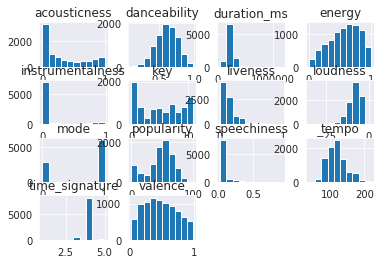

In [0]:
# drop boolean
Data.drop(['explicit'], axis=1).hist();

### Scale Data

In [10]:
Data_raw = Data.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data = scaler.fit_transform(Data_raw.drop(['explicit'], axis=1))
Data = pd.DataFrame(Data, columns=Data_raw.drop(['explicit'], axis=1).columns)
Data['explicit'] = Data_raw['explicit']
Data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
count,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000,8802.000000
mean,0.336061,0.567995,0.159290,0.568958,0.134537,0.473746,0.157259,0.725579,0.679959,0.461296,0.052393,0.445857,0.734606,0.473326
std,0.330687,0.171361,0.055921,0.237372,0.280464,0.326309,0.137342,0.113513,0.466518,0.207339,0.081483,0.154506,0.080505,0.258194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038076,0.451136,0.126644,0.394140,0.000001,0.181818,0.081179,0.671320,0.000000,0.360000,0.012322,0.331952,0.750000,0.262444
50%,0.207830,0.575000,0.152558,0.592750,0.000301,0.454545,0.103083,0.747339,1.000000,0.500000,0.022740,0.441899,0.750000,0.457550
75%,0.624497,0.693182,0.184163,0.757255,0.052268,0.727273,0.179902,0.805178,1.000000,0.600000,0.049849,0.530232,0.750000,0.675777
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


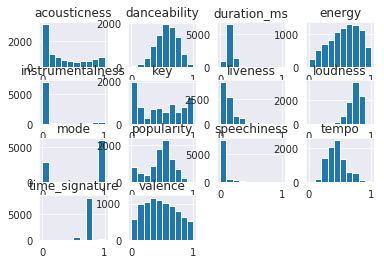

In [0]:
Data.drop(['explicit'], axis=1).hist();

## Model Selection

### L1 Regularization

In [11]:
#from sklearn.linear_model import LogisticRegression
lasso = LogisticRegression(penalty='l1')

model_desc.append("lasso")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=lasso,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: lasso


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Training score: 0.8124526586880776

Validation score: 0.7846433439345752


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur


Cross validation: 80.5045 +/- 0.0018%


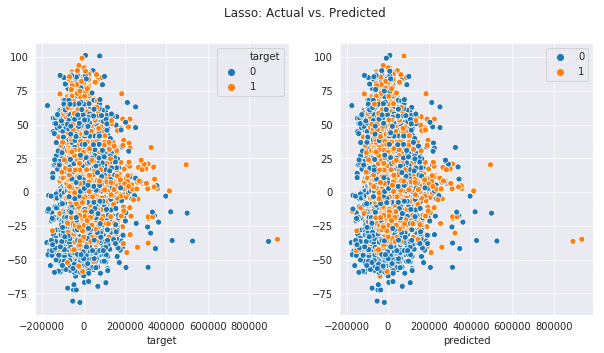

In [12]:
y_pred = lasso.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Lasso: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### L2 Regularization

In [13]:
#from sklearn.linear_model import LogisticRegression
ridge = LogisticRegression(penalty='l2')
model_desc.append("ridge")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=ridge,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: ridge

Training score: 0.8076049083472201

Validation score: 0.797364834166288


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Cross validation: 80.425 +/- 0.001%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


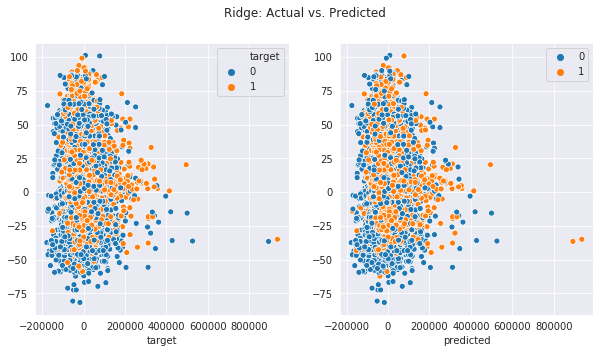

In [14]:
y_pred = ridge.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Ridge: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Decision Tree

In [15]:
#from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
model_desc.append("decision tree")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=tree,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: decision tree

Training score: 0.9998485078018482

Validation score: 0.7355747387551114

Cross validation: 73.4267 +/- 0.028%


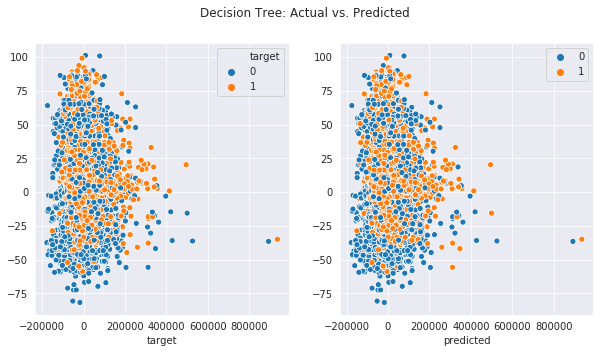

In [16]:
y_pred = tree.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Decision Tree: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### K-Nearest Neighbors

In [17]:
#from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model_desc.append("k-nearest neighbors")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=knn,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: k-nearest neighbors

Training score: 0.8488107862445085

Validation score: 0.7719218537028624

Cross validation: 78.0276 +/- 0.0045%


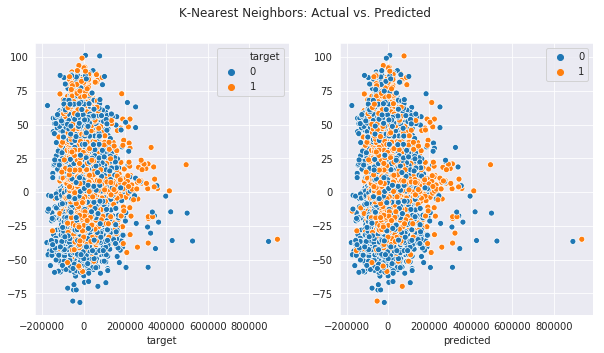

In [18]:
y_pred = knn.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "K-Nearest Neighbors: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Random Forest

In [19]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
model_desc.append("random forest")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=rfc,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: random forest

Training score: 0.9996970156036964

Validation score: 0.8187187641980918

Cross validation: 81.6861 +/- 0.0018%


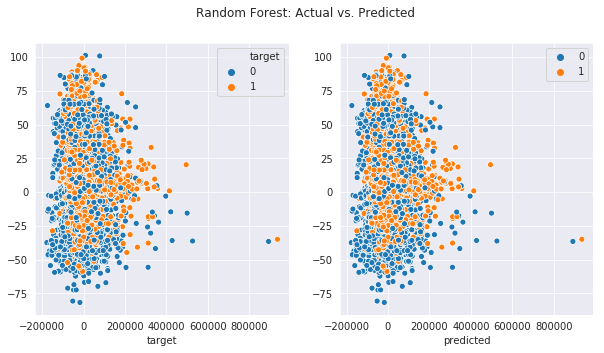

In [20]:
y_pred = rfc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Random Forest: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Multilayer Perceptron

In [21]:
#from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
model_desc.append("multilayer perceptron")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=mlp,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: multilayer perceptron

Training score: 0.8106347523102561

Validation score: 0.809631985461154


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Cross validation: 81.1406 +/- 0.0009%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


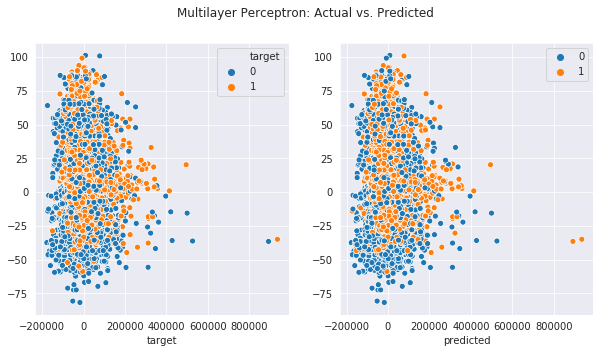

In [22]:
y_pred = mlp.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Multilayer Perceptron: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Gradient Boosting

In [23]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1)
model_desc.append("gradient boosting")
print("Model: {}".format(model_desc[-1]))

new_score = supervised_clf(model=gbc,
                           data=Data,
                           target=target,
                           stratify=target)
model_score = model_score.append(new_score, ignore_index=True)

Model: gradient boosting

Training score: 0.8427510983184366

Validation score: 0.8205361199454794

Cross validation: 81.754 +/- 0.0016%


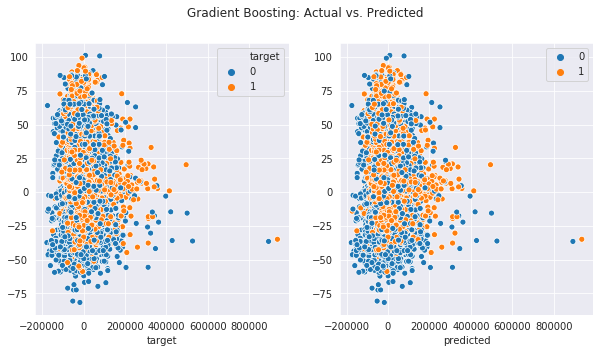

In [24]:
y_pred = gbc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Gradient Boosting: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Assessment

In [25]:
model_score[["cv_score", "variance"]].describe()

,cv_score,variance
count,7.000000,7.000000
mean,79.566357,0.005657
std,2.984345,0.009925
min,73.426700,0.000900
25%,79.226300,0.001300
50%,80.504500,0.001800
75%,81.413350,0.003150
max,81.754000,0.028000


In [26]:
model_score = pd.concat([pd.Series(model_desc, name="model"), model_score], axis=1)
model_score.sort_values(by=["cv_score"], ascending=False).head(5)

,model,train_score,test_score,cv_score,variance
6,gradient boosting,0.842751,0.820536,81.7540,0.0016
4,random forest,0.999697,0.818719,81.6861,0.0018
5,multilayer perceptron,0.810635,0.809632,81.1406,0.0009
0,lasso,0.812453,0.784643,80.5045,0.0018
1,ridge,0.807605,0.797365,80.4250,0.0010


## Model Tuning

In [27]:
#from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifier().get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [0]:
# learning rate 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'auto', None]
# Maximum number of levels in tree
max_depths = [int(x) for x in np.linspace(10, 110, num=11)]
max_depths.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# boosting
warm_start = [True, False]

# Create the random grid
param_grid = {'learning_rate': learning_rates,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depths,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'warm_start': warm_start}

In [0]:
# split data
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target)

# sample data for parameter search
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train)

In [30]:
%%time
from sklearn.model_selection import RandomizedSearchCV

model = GradientBoostingClassifier()

search = RandomizedSearchCV(model, param_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1)

search.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


CPU times: user 2.45 s, sys: 158 ms, total: 2.6 s
Wall time: 2min 25s


In [31]:
best_params = search.best_params_
print(best_params)

{'warm_start': False, 'n_estimators': 200, 'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_features': 'auto', 'max_depth': 100, 'learning_rate': 0.25}


## Final Model

In [0]:
# hard code best parameters
best_params = {'warm_start': True,
               'n_estimators': 400,
               'min_samples_split': 0.4,
               'min_samples_leaf': 0.2,
               'max_features': 'log2',
               'max_depth': 90,
               'learning_rate': 0.05}

In [32]:
model = GradientBoostingClassifier(**best_params)
supervised_clf(model, Data, target, stratify=target)


Training score: 0.8369943947886684

Validation score: 0.8132666969559291

Cross validation: 81.7086 +/- 0.002%


,train_score,test_score,cv_score,variance
0,0.836994,0.813267,81.7086,0.002


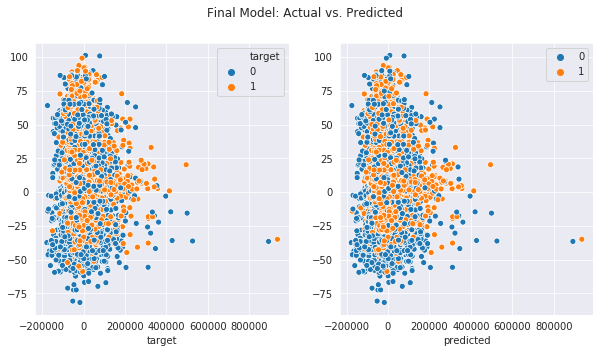

In [33]:
y_pred = model.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Final Model: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall: 85.65447333627148%
Precision: 84.04020593282668%


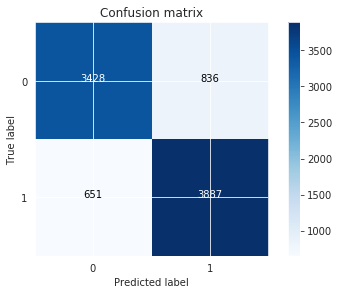

In [35]:
cnf_matrix = confusion_matrix(target, y_pred)

recall_metric = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall: {}%".format(recall_metric))

precision_metric = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision: {}%".format(precision_metric))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
#plt.savefig('.png')
plt.show()

ROC-AUC: 0.830


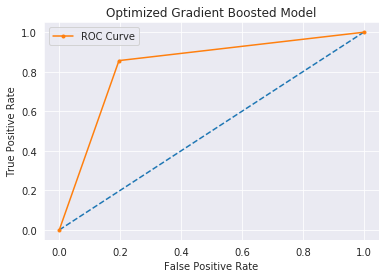

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculate AUC
roc_auc = roc_auc_score(target, y_pred)
print('ROC-AUC: %.3f' % roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(target, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Optimized Gradient Boosted Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig('.png')
plt.show()

f1=0.839 auc=0.877 ap=0.779


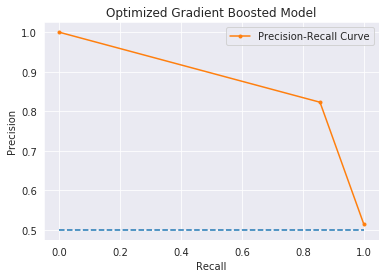

In [38]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import auc, average_precision_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(target, y_pred)
# calculate F1 score
f1_score = f1_score(target, y_pred)
# calculate precision-recall AUC
precision_recall_auc = auc(recall, precision)
# calculate average precision score
avg_precision = average_precision_score(target, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_score,
                                    precision_recall_auc,
                                    avg_precision))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Optimized Gradient Boosted Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
#plt.savefig('.png')
plt.show()

## Conclusion

Our models had mixed performance, some failing to achieve an accuracy above 50% while the best models had an accuracy closer to 80%. With tuning, we weren't able to improve our model much over its base performance.

Ultimately, using audio data made available from Spotify, we were able to classify song mood with ~80% accuracy and very low variance.